In [1]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


In [ ]:
from sentinelhub import SHConfig
from dotenv import load_dotenv
import os

config = SHConfig(sh_client_id=os.environ.get("sh_client_id"), sh_client_secret=os.environ.get("sh_client_secret"))
config.sh_client_id

'65f2b211-b283-42d5-9ac6-d3ecf4be5a45'

In [ ]:
def plot_image(
    image: np.ndarray, factor: float = 1.0, clip_range: tuple[float, float] | None = None, **kwargs) -> None:
    """Utility function for plotting RGB images."""
    _, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

In [15]:
import datetime
import os

import matplotlib.pyplot as plt
import numpy as np

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)


cords = (80.085375,12.894645,80.1,12.906943)

resolution = 0.8
bbox = BBox(bbox=cords, crs=CRS.WGS84)
size = bbox_to_dimensions(bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {size} pixels")

Image shape at 0.8 m resolution: (1989, 1693) pixels


In [ ]:
from utils import evalscript_true_color, evalscript_ndvi, evalscript_ndwi

In [87]:
size

(1989, 1693)

In [104]:
import ee
import geemap

# Authenticate and initialize
ee.Authenticate()
ee.Initialize()

def get_map(cords, start_date, end_date, evalscript_true_color, evalscript_ndvi, evalscript_ndwi, resolution=0.8):

    bbox = BBox(bbox=cords, crs=CRS.WGS84)
    size = bbox_to_dimensions(bbox, resolution=resolution)

    request_true_color = SentinelHubRequest(
        evalscript=evalscript_true_color,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L1C,
                time_interval=(start_date, end_date),
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
        bbox=bbox,
        size=size,
        config=config,
    )
    rgb_response = request_true_color.get_data()
    
    request_ndvi = SentinelHubRequest(
        evalscript=evalscript_ndvi,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=(start_date, end_date),
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=bbox,
        size=size,
        config=config,
    )
    ndvi_response = request_ndvi.get_data()[0]

    request_ndwi = SentinelHubRequest(
        evalscript=evalscript_ndwi,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=(start_date, end_date),
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=bbox,
        size=size,
        config=config,
    )
    ndwi_response = request_ndwi.get_data()[0]

    # Load the SRTM DEM dataset
    srtm = ee.Image("USGS/SRTMGL1_003")

    # Calculate slope using the `terrain` function
    terrain = ee.Algorithms.Terrain(srtm)

    # Extract elevation and slope
    elevation = srtm.select('elevation')  # Elevation data
    slope = terrain.select('slope') 

    srtm = ee.Image("USGS/SRTMGL1_003")
    terrain = ee.Algorithms.Terrain(srtm)
    elevation = srtm.select('elevation')  # Elevation data
    slope = terrain.select('slope') 

    roi = ee.Geometry.Rectangle(*cords) 

    Map = geemap.Map()
    Map.centerObject(roi, 16)

    # Add elevation and slope layers
    Map.addLayer(elevation.clip(roi), {'min': 0, 'max': 3000, 'palette': ['black', 'white', 'gray']}, 'Elevation')
    Map.addLayer(slope.clip(roi), {'min': 0, 'max': 60, 'palette': ['black', 'white', 'gray']}, 'Slope')

    elevation_arr = geemap.ee_to_numpy(elevation.resample('bicubic'), region=roi)
    slope_arr = geemap.ee_to_numpy(slope, region=roi)

    return (rgb_response[0]*3.5/255).clip(0,1), ndvi_response*3.5/255, ndwi_response*3.5/255, elevation_arr, slope_arr



In [105]:
maps = get_map(cords, start_date="2020-06-12", end_date="2021-06-13", 
        evalscript_ndvi=evalscript_ndvi, 
        evalscript_true_color=evalscript_true_color, 
        evalscript_ndwi=evalscript_ndwi)

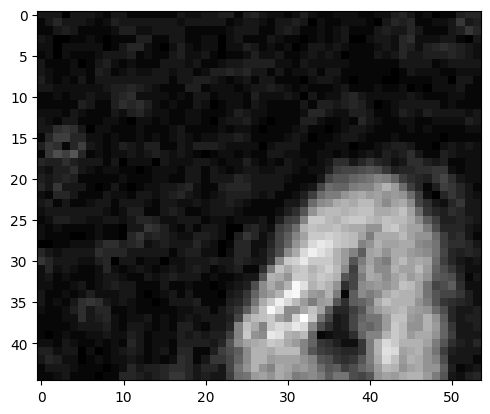

In [109]:
plt.imshow(maps[4], cmap="gray")